In [ ]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.optim as optim

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# For handling file paths and directories
import os
import sys
import h5py

# Optional: If your model or data processing requires specific numerical operations (e.g., FFT)
from torch.fft import fft, ifft


# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)
current_dir = os.getcwd()



Using Device: cuda
Using PyTorch version: 2.5.1


In [3]:
def load_and_process_dataset(data_path, print_dataset=True):
    start_time = time.time()
    (designs, design_params, n_designs, n_panes, design_res,
     WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors,
     EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x,
     EIGENVECTOR_DATA_y, const, N_struct,
     imag_tol, rng_seed_offset) = NO_utils.extract_data(data_path)

    print(f"Loading dataset path: {data_path}")
    # Take first pane of designs
    designs = designs[:,0,:,:]

    # Convert WAVEVECTOR_DATA to spatial domain
    WAVEFORM_DATA = NO_utils_multiple.embed_2const_wavelet(WAVEVECTOR_DATA[0,:,0], WAVEVECTOR_DATA[0,:,1], size=design_res) #(600, 325, 2)

    # Convert all bands to spatial domain
    bands = np.arange(1, n_bands + 1)
    bands_fft = NO_utils_multiple.embed_integer_wavelet(bands, size=design_res)

    # Create the result dictionary
    dataset = {
        "designs": designs, "design_params": design_params, "n_designs": n_designs,
        "WAVEVECTOR_DATA": WAVEVECTOR_DATA, "WAVEFORM_DATA": WAVEFORM_DATA,
        "EIGENVALUE_DATA": EIGENVALUE_DATA, "EIGENVECTOR_DATA_x": EIGENVECTOR_DATA_x,
        "EIGENVECTOR_DATA_y": EIGENVECTOR_DATA_y, "bands_fft": bands_fft
    }
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print dataset sizes and elapsed time
    if print_dataset:
        print(f"Dataset loaded from {data_path}:")
        for key, value in dataset.items():
            print(f"  {key}: {np.shape(value)}")
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return dataset

def save_dataset(save_path, designs=None, design_params=None, waveforms=None, wavevectors=None, 
                eigenvalue_data=None, eigenvector_data_x=None, eigenvector_data_y=None, bands_fft=None):
    """
    Save dataset arrays to a specified path.
    
    Parameters:
    - save_path: Path to save the dataset
    - designs: Array of design patterns (optional)
    - design_params: Array of design parameters (optional)
    - waveforms: Array of waveform data (optional)
    - wavevectors: Array of wavevector data (optional)
    - eigenvalue_data: Array of eigenvalues (optional)
    - eigenvector_data_x: Array of x-component eigenvectors (optional)
    - eigenvector_data_y: Array of y-component eigenvectors (optional)
    - bands_fft: Array of band data in Fourier space (optional)
    """
    os.makedirs(save_path, exist_ok=True)
    
    print(f"Dataset saved to {save_path}")
    
    # Save each array with np.save if provided
    if designs is not None:
        np.save(os.path.join(save_path, 'designs.npy'), designs.astype(np.float16))
        saved_arrays = ['designs']
    if design_params is not None:
        np.save(os.path.join(save_path, 'design_params.npy'), design_params.astype(np.float16))
        saved_arrays.append('design_params')
    if waveforms is not None:
        np.save(os.path.join(save_path, 'waveforms.npy'), waveforms.astype(np.float16))
        saved_arrays.append('waveforms')
    if wavevectors is not None:
        np.save(os.path.join(save_path, 'wavevectors.npy'), wavevectors.astype(np.float16))
        saved_arrays.append('wavevectors')
    if eigenvalue_data is not None:
        np.save(os.path.join(save_path, 'eigenvalue_data.npy'), eigenvalue_data)
        saved_arrays.append('eigenvalue_data')
    if eigenvector_data_x is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_x.npy'), eigenvector_data_x)
        saved_arrays.append('eigenvector_data_x')
    if eigenvector_data_y is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_y.npy'), eigenvector_data_y)
        saved_arrays.append('eigenvector_data_y')
    if bands_fft is not None:
        np.save(os.path.join(save_path, 'bands_fft.npy'), bands_fft.astype(np.float16))
        saved_arrays.append('bands_fft')
    
    print(f"Saved arrays: {', '.join(saved_arrays)}")

def load_dataset(load_path, drop_redundant=True):
    """
    Load dataset arrays from a specified path.
    
    Parameters:
    - load_path: Path to load the dataset from
    
    Returns:
    - designs: Array of design patterns
    - design_params: Array of design parameters
    - waveforms: Array of waveform data
    - wavevectors: Array of wavevector data
    - eigenvalue_data: Array of eigenvalues
    - eigenvector_data_x: Array of x-component eigenvectors
    - eigenvector_data_y: Array of y-component eigenvectors
    - bands_fft: Array of band data in Fourier space
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Dataset directory {load_path} does not exist")
    
    # Load each array with np.load
    if drop_redundant:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    else:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    design_params = np.load(os.path.join(load_path, 'design_params.npy'))
    eigenvalue_data = np.load(os.path.join(load_path, 'eigenvalue_data.npy'))
    eigenvector_data_x = np.load(os.path.join(load_path, 'eigenvector_data_x.npy'))
    eigenvector_data_y = np.load(os.path.join(load_path, 'eigenvector_data_y.npy'))
    bands_fft = np.load(os.path.join(load_path, 'bands_fft.npy'))
    
    print(f"Dataset loaded from {load_path}")
    
    return designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft

## Make converted f16 datasets

In [14]:
def convert_dataset_to_float16(input_folder, output_folder):
    """
    Convert dataset from input folder to float16 and save to output folder.
    
    Args:
        input_folder (str): Name of the input folder (e.g., 'set 1')
        output_folder (str): Name of the output folder (e.g., 'set 1 f16')
    """
    # Construct full paths
    input_path = os.path.join(current_dir, 'data', input_folder)
    output_path = os.path.join(current_dir, 'data', output_folder)
    
    print(f"Loading data from {input_path}...")
    
    # Load the data
    designs = np.load(os.path.join(input_path, "designs.npy"))
    design_params = np.load(os.path.join(input_path, "design_params.npy"))
    waveforms = np.load(os.path.join(input_path, "waveforms.npy"))
    wavevectors = np.load(os.path.join(input_path, "wavevectors.npy"))
    eigenvalue_data = np.load(os.path.join(input_path, "eigenvalue_data.npy"))
    eigenvector_data_x = np.load(os.path.join(input_path, "eigenvector_data_x.npy"))
    eigenvector_data_y = np.load(os.path.join(input_path, "eigenvector_data_y.npy"))
    bands_fft = np.load(os.path.join(input_path, "bands_fft.npy"))
    
    print("Data loaded successfully!")
    print(f"designs shape: {designs.shape}, dtype: {designs.dtype}")
    print(f"design_params shape: {design_params.shape}, dtype: {design_params.dtype}")
    print(f"waveforms shape: {waveforms.shape}, dtype: {waveforms.dtype}")
    print(f"wavevectors shape: {wavevectors.shape}, dtype: {wavevectors.dtype}")
    print(f"eigenvalue_data shape: {eigenvalue_data.shape}, dtype: {eigenvalue_data.dtype}")
    print(f"eigenvector_data_x shape: {eigenvector_data_x.shape}, dtype: {eigenvector_data_x.dtype}")
    print(f"eigenvector_data_y shape: {eigenvector_data_y.shape}, dtype: {eigenvector_data_y.dtype}")
    print(f"bands_fft shape: {bands_fft.shape}, dtype: {bands_fft.dtype}")
    
    print("\nConverting data to float16...")
    
    # Convert to float16
    designs = designs.astype(np.float16)
    waveforms = waveforms.astype(np.float16)
    bands_fft = bands_fft.astype(np.float16)
    
    # For eigenvector data, separate real and imaginary components and convert to float16
    eigenvector_data_x_real = np.real(eigenvector_data_x).astype(np.float16)
    eigenvector_data_x_imag = np.imag(eigenvector_data_x).astype(np.float16)
    eigenvector_data_y_real = np.real(eigenvector_data_y).astype(np.float16)
    eigenvector_data_y_imag = np.imag(eigenvector_data_y).astype(np.float16)
    
    print("Data conversion to float16 completed.")
    print(f"designs new dtype: {designs.dtype}, shape: {designs.shape}")
    print(f"waveforms new dtype: {waveforms.dtype}, shape: {waveforms.shape}")
    print(f"bands_fft new dtype: {bands_fft.dtype}, shape: {bands_fft.shape}")
    print(f"eigenvector_data_x_real dtype: {eigenvector_data_x_real.dtype}, shape: {eigenvector_data_x_real.shape}")
    print(f"eigenvector_data_x_imag dtype: {eigenvector_data_x_imag.dtype}, shape: {eigenvector_data_x_imag.shape}")
    print(f"eigenvector_data_y_real dtype: {eigenvector_data_y_real.dtype}, shape: {eigenvector_data_y_real.shape}")
    print(f"eigenvector_data_y_imag dtype: {eigenvector_data_y_imag.dtype}, shape: {eigenvector_data_y_imag.shape}")
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    print(f"\nSaving converted data to {output_path}...")
    
    # Save the converted arrays
    np.save(os.path.join(output_path, "designs.npy"), designs)
    np.save(os.path.join(output_path, "design_params.npy"), design_params)
    np.save(os.path.join(output_path, "waveforms.npy"), waveforms)
    np.save(os.path.join(output_path, "wavevectors.npy"), wavevectors)
    np.save(os.path.join(output_path, "eigenvalue_data.npy"), eigenvalue_data)
    np.save(os.path.join(output_path, "eigenvector_data_x_real.npy"), eigenvector_data_x_real)
    np.save(os.path.join(output_path, "eigenvector_data_x_imag.npy"), eigenvector_data_x_imag)
    np.save(os.path.join(output_path, "eigenvector_data_y_real.npy"), eigenvector_data_y_real)
    np.save(os.path.join(output_path, "eigenvector_data_y_imag.npy"), eigenvector_data_y_imag)
    np.save(os.path.join(output_path, "bands_fft.npy"), bands_fft)
    
    print("Data saved successfully!")
    print(f"Files saved in {output_path}:")
    for filename in os.listdir(output_path):
        if filename.endswith('.npy'):
            print(f"  - {filename}")
    
    return designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x_real, eigenvector_data_x_imag, eigenvector_data_y_real, eigenvector_data_y_imag, bands_fft

In [ ]:
# Convert all continuous datasets to float16
_ = convert_dataset_to_float16('set 1', 'set1_f16')
_ = convert_dataset_to_float16('set 2', 'set2_f16')
_ = convert_dataset_to_float16('set 3', 'set3_f16')
_ = convert_dataset_to_float16('set 4', 'set4_f16')
_ = convert_dataset_to_float16('set 5', 'set5_f16')
_ = convert_dataset_to_float16('set 6', 'set6_f16')
_ = convert_dataset_to_float16('set 7', 'set7_f16')
_ = convert_dataset_to_float16('set 8', 'set8_f16')
_ = convert_dataset_to_float16('set 9', 'set9_f16')
_ = convert_dataset_to_float16('set 10', 'set10_f16')
_ = convert_dataset_to_float16('set 11', 'set11_f16')
_ = convert_dataset_to_float16('set 12', 'set12_f16')
_ = convert_dataset_to_float16('set 13', 'set13_f16')
_ = convert_dataset_to_float16('set 14', 'set14_f16')
_ = convert_dataset_to_float16('set 15', 'set15_f16')
_ = convert_dataset_to_float16('set 16', 'set16_f16')

## Make reduced datasets from converted datasets

In [20]:
# Load a .pt file and print the shape of the data
reduced_datapath1 = os.path.join(current_dir, 'data', 'reduced', 'set 1', 'reduced_dataset1_ws4_bs2_f16.pt')

In [25]:
# Load data from set1_f16
set1_f16_path = os.path.join(current_dir, 'data', 'set1_f16')

designs1 = np.load(os.path.join(set1_f16_path, "designs.npy"))
design_params1 = np.load(os.path.join(set1_f16_path, "design_params.npy"))
waveforms1 = np.load(os.path.join(set1_f16_path, "waveforms.npy"))
wavevectors1 = np.load(os.path.join(set1_f16_path, "wavevectors.npy"))
eigenvalue_data1 = np.load(os.path.join(set1_f16_path, "eigenvalue_data.npy"))
eigenvector_data_x_real1 = np.load(os.path.join(set1_f16_path, "eigenvector_data_x_real.npy"))
eigenvector_data_x_imag1 = np.load(os.path.join(set1_f16_path, "eigenvector_data_x_imag.npy"))
eigenvector_data_y_real1 = np.load(os.path.join(set1_f16_path, "eigenvector_data_y_real.npy"))
eigenvector_data_y_imag1 = np.load(os.path.join(set1_f16_path, "eigenvector_data_y_imag.npy"))
bands_fft1 = np.load(os.path.join(set1_f16_path, "bands_fft.npy"))

print("Set1_f16 data loaded successfully!")
print(f"Designs shape: {designs1.shape}, dtype: {designs1.dtype}")
print(f"Design params shape: {design_params1.shape}, dtype: {design_params1.dtype}")
print(f"Waveforms shape: {waveforms1.shape}, dtype: {waveforms1.dtype}")
print(f"Wavevectors shape: {wavevectors1.shape}, dtype: {wavevectors1.dtype}")
print(f"Eigenvalue data shape: {eigenvalue_data1.shape}, dtype: {eigenvalue_data1.dtype}")
print(f"Eigenvector data x real shape: {eigenvector_data_x_real1.shape}, dtype: {eigenvector_data_x_real1.dtype}")
print(f"Eigenvector data x imag shape: {eigenvector_data_x_imag1.shape}, dtype: {eigenvector_data_x_imag1.dtype}")
print(f"Eigenvector data y real shape: {eigenvector_data_y_real1.shape}, dtype: {eigenvector_data_y_real1.dtype}")
print(f"Eigenvector data y imag shape: {eigenvector_data_y_imag1.shape}, dtype: {eigenvector_data_y_imag1.dtype}")
print(f"Bands FFT shape: {bands_fft1.shape}, dtype: {bands_fft1.dtype}")


Set1_f16 data loaded successfully!
Designs shape: (600, 32, 32), dtype: float16
Design params shape: (1, 6), dtype: uint32
Waveforms shape: (325, 32, 32), dtype: float16
Wavevectors shape: (325, 2), dtype: float16
Eigenvalue data shape: (600, 325, 6), dtype: float16
Eigenvector data x real shape: (600, 325, 6, 32, 32), dtype: float16
Eigenvector data x imag shape: (600, 325, 6, 32, 32), dtype: float16
Eigenvector data y real shape: (600, 325, 6, 32, 32), dtype: float16
Eigenvector data y imag shape: (600, 325, 6, 32, 32), dtype: float16
Bands FFT shape: (6, 32, 32), dtype: float16


In [35]:
# Take random subsets of datasets to reduce the total size but keep a representative distribution of the data
waveform_subset_proportion = 0.2
bands_subset_proportion = 0.5
waveform_subset_size = int(325 * waveform_subset_proportion)
bands_subset_size = int(6 * bands_subset_proportion)
geometry_size = 600
reduced_dataset_size = geometry_size*waveform_subset_size*bands_subset_size

# Initialize list of index tuples for the reduced dataset with preallocated size
reduced_indices_reserved = [None] * reduced_dataset_size
print(f'Target reduced dataset size: {reduced_dataset_size}')

# Track the current index for insertion
current_idx = 0

# For each design, select random subsets of waveforms and bands
for d_idx in range(geometry_size):
    # Get random waveform indices (0 to 324)
    waveform_indices = np.random.choice(325, size=waveform_subset_size, replace=False)
    
    for w_idx in waveform_indices:
        # Get random band indices (0 to 5) 
        band_indices = np.random.choice(6, size=bands_subset_size, replace=False)
        
        # Add index tuples for this design's samples
        for b_idx in band_indices:
            reduced_indices_reserved[current_idx] = (d_idx, w_idx, b_idx)
            current_idx += 1

print(f'reduced_indices length: {len(reduced_indices_reserved)}')
print(f'Second element of reduced_indices_reserved: {reduced_indices_reserved[420]}')


Target reduced dataset size: 117000
reduced_indices length: 117000
Second element of reduced_indices_reserved: (2, 20, 4)


In [36]:
# Create reduced dataset using the tuple list
print("Creating reduced dataset from selected indices...")

# Extract subset using the index tuples
eigenvector_data_x_real_reduced = eigenvector_data_x_real1[
    [idx[0] for idx in reduced_indices_reserved],
    [idx[1] for idx in reduced_indices_reserved],
    [idx[2] for idx in reduced_indices_reserved]
]

eigenvector_data_x_imag_reduced = eigenvector_data_x_imag1[
    [idx[0] for idx in reduced_indices_reserved],
    [idx[1] for idx in reduced_indices_reserved],
    [idx[2] for idx in reduced_indices_reserved]
]

eigenvector_data_y_real_reduced = eigenvector_data_y_real1[
    [idx[0] for idx in reduced_indices_reserved],
    [idx[1] for idx in reduced_indices_reserved],
    [idx[2] for idx in reduced_indices_reserved]
]

eigenvector_data_y_imag_reduced = eigenvector_data_y_imag1[
    [idx[0] for idx in reduced_indices_reserved],
    [idx[1] for idx in reduced_indices_reserved],
    [idx[2] for idx in reduced_indices_reserved]
]

print(f"Reduced eigenvector x real shape: {eigenvector_data_x_real_reduced.shape}")
print(f"Reduced eigenvector x imag shape: {eigenvector_data_x_imag_reduced.shape}")
print(f"Reduced eigenvector y real shape: {eigenvector_data_y_real_reduced.shape}")
print(f"Reduced eigenvector y imag shape: {eigenvector_data_y_imag_reduced.shape}")


Creating reduced dataset from selected indices...
Reduced eigenvector x real shape: (117000, 32, 32)
Reduced eigenvector x imag shape: (117000, 32, 32)
Reduced eigenvector y real shape: (117000, 32, 32)
Reduced eigenvector y imag shape: (117000, 32, 32)


In [42]:
# Save the reduced dataset
reduced_datapath1 = os.path.join(current_dir, 'data', 'set1_f16_reduced_wv5_b2')
os.makedirs(reduced_datapath1, exist_ok=True)

reduced_data = torch.utils.data.TensorDataset(
    torch.from_numpy(eigenvector_data_x_real_reduced),
    torch.from_numpy(eigenvector_data_x_imag_reduced),
    torch.from_numpy(eigenvector_data_y_real_reduced),
    torch.from_numpy(eigenvector_data_y_imag_reduced)
)
# Save dataset components as separate files (full versions)
# The reduced_indices_reserved will be used to reconstruct the reduced form

# Save each component separately (full arrays)
torch.save(reduced_data, os.path.join(reduced_datapath1, "tensor_dataset.pt"))
torch.save(reduced_indices_reserved, os.path.join(reduced_datapath1, "reduced_indices.pt"))
torch.save(torch.from_numpy(designs1), os.path.join(reduced_datapath1, "geometries_full.pt"))
torch.save(torch.from_numpy(waveforms1), os.path.join(reduced_datapath1, "waveforms_full.pt"))
torch.save(torch.from_numpy(wavevectors1), os.path.join(reduced_datapath1, "wavevectors_full.pt"))
torch.save(torch.from_numpy(bands_fft1), os.path.join(reduced_datapath1, "band_fft_full.pt"))
torch.save(torch.from_numpy(design_params1.astype(np.int64)), os.path.join(reduced_datapath1, "design_params_full.pt"))

In [ ]:
def reduce_dataset(input_folder, output_folder, WVR, BR, DO=0):
    """
    Reduce a dataset by selecting specific wavevectors and bands, then save the reduced dataset.
    
    Parameters:
    - input_folder: Path to the input dataset folder
    - output_folder: Path to save the reduced dataset
    - WVR: Wavevector reduction ratio for random selection (e.g., 0.2 means keep 20% of wavevectors)
    - BR: Band reduction ratio for random selection (e.g., 0.5 means keep 50% of bands)
    - DO: Dataset offset (adds DO to geometry index)
    """
    
    # Construct full paths
    input_path = os.path.join(current_dir, 'data', input_folder)
    output_path = os.path.join(current_dir, 'data', output_folder)
    
    print(f"Loading data from {input_path}...")

    # Load data from input folder
    designs = np.load(os.path.join(input_path, "designs.npy"))
    waveforms = np.load(os.path.join(input_path, "waveforms.npy"))
    wavevectors = np.load(os.path.join(input_path, "wavevectors.npy"))
    bands_fft = np.load(os.path.join(input_path, "bands_fft.npy"))
    design_params = np.load(os.path.join(input_path, "design_params.npy"))
    eigenvector_data_x_real = np.load(os.path.join(input_path, "eigenvector_data_x_real.npy"))
    eigenvector_data_x_imag = np.load(os.path.join(input_path, "eigenvector_data_x_imag.npy"))
    eigenvector_data_y_real = np.load(os.path.join(input_path, "eigenvector_data_y_real.npy"))
    eigenvector_data_y_imag = np.load(os.path.join(input_path, "eigenvector_data_y_imag.npy"))
    
    print(f"Original data shapes:")
    print(f"Designs: {designs.shape}")
    print(f"Waveforms: {waveforms.shape}")
    print(f"Wavevectors: {wavevectors.shape}")
    print(f"Bands FFT: {bands_fft.shape}")
    print(f"Design params: {design_params.shape}")
    print(f"Eigenvector x real: {eigenvector_data_x_real.shape}")
    print(f"Eigenvector x imag: {eigenvector_data_x_imag.shape}")
    print(f"Eigenvector y real: {eigenvector_data_y_real.shape}")
    print(f"Eigenvector y imag: {eigenvector_data_y_imag.shape}")
    
    # Apply dataset offset to geometry indices
    if DO != 0:
        print(f"Applying dataset offset: {DO} (adding {DO} to geometry indices)")
        # Assuming first column is geometry index
        design_params[:, 0] += DO
    
    wavevectors_reduced_amount = int(wavevectors.shape[0] * WVR)
    bands_fft_reduced_amount = int(bands_fft.shape[0] * BR)
    samples_reduced_amount = int(designs.shape[0] * wavevectors_reduced_amount * bands_fft_reduced_amount)
    reduced_indices_reserved = [None] * samples_reduced_amount

    # Track the current index for insertion
    current_idx = 0

    # For each design, select random subsets of waveforms and bands
    for d_idx in range(designs.shape[0]):
        # Get random waveform indices (0 to 324)
        waveform_indices = np.random.choice(waveforms.shape[0], size=wavevectors_reduced_amount, replace=False)
        
        for w_idx in waveform_indices:
            # Get random band indices (0 to 5) 
            band_indices = np.random.choice(bands_fft.shape[0], size=bands_fft_reduced_amount, replace=False)
            
            # Add index tuples for this design's samples
            for b_idx in band_indices:
                reduced_indices_reserved[current_idx] = (d_idx, w_idx, b_idx)
                current_idx += 1
    
    print(f"Total reduced indices: {len(reduced_indices_reserved)}")
    print(f"Original total elements: {eigenvector_data_x_real.size}")
    print(f"Reduction ratio: {eigenvector_data_x_real[0] / len(reduced_indices_reserved):.2f}")
    
    # Extract reduced data using the indices
    eigenvector_data_x_real_reduced = eigenvector_data_x_real[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    eigenvector_data_x_imag_reduced = eigenvector_data_x_imag[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    eigenvector_data_y_real_reduced = eigenvector_data_y_real[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    eigenvector_data_y_imag_reduced = eigenvector_data_y_imag[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    
    print(f"Reduced eigenvector x real shape: {eigenvector_data_x_real_reduced.shape}")
    print(f"Reduced eigenvector x imag shape: {eigenvector_data_x_imag_reduced.shape}")
    print(f"Reduced eigenvector y real shape: {eigenvector_data_y_real_reduced.shape}")
    print(f"Reduced eigenvector y imag shape: {eigenvector_data_y_imag_reduced.shape}")
    
    # Create output directory
    os.makedirs(output_path, exist_ok=True)
    
    # Create and save reduced dataset
    reduced_data = torch.utils.data.TensorDataset(
        torch.from_numpy(eigenvector_data_x_real_reduced),
        torch.from_numpy(eigenvector_data_x_imag_reduced),
        torch.from_numpy(eigenvector_data_y_real_reduced),
        torch.from_numpy(eigenvector_data_y_imag_reduced)
    )
    
    # Save dataset components as separate files
    torch.save(reduced_data, os.path.join(output_path, "tensor_dataset.pt"))
    torch.save(reduced_indices_reserved, os.path.join(output_path, "reduced_indices.pt"))
    torch.save(torch.from_numpy(designs), os.path.join(output_path, "geometries_full.pt"))
    torch.save(torch.from_numpy(waveforms), os.path.join(output_path, "waveforms_full.pt"))
    torch.save(torch.from_numpy(wavevectors), os.path.join(output_path, "wavevectors_full.pt"))
    torch.save(torch.from_numpy(bands_fft), os.path.join(output_path, "band_fft_full.pt"))
    torch.save(torch.from_numpy(design_params.astype(np.int64)), os.path.join(output_path, "design_params_full.pt"))
    
    print(f"Reduced dataset saved to: {output_path}")
    return {
        'tensor_dataset': reduced_data,
        'reduced_indices': reduced_indices_reserved,
        'geometries_full': torch.from_numpy(designs),
        'waveforms_full': torch.from_numpy(waveforms),
        'wavevectors_full': torch.from_numpy(wavevectors),
        'band_fft_full': torch.from_numpy(bands_fft),
        'design_params_full': torch.from_numpy(design_params.astype(np.int64)),
    }

In [54]:
_ = reduce_dataset('set2_f16', 'set2_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(2-1))
_ = reduce_dataset('set3_f16', 'set3_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(3-1))
_ = reduce_dataset('set4_f16', 'set4_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(4-1))
_ = reduce_dataset('set5_f16', 'set5_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(5-1))
_ = reduce_dataset('set6_f16', 'set6_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(6-1))
_ = reduce_dataset('set7_f16', 'set7_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(7-1))
_ = reduce_dataset('set8_f16', 'set8_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(8-1))
_ = reduce_dataset('set9_f16', 'set9_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(9-1))
_ = reduce_dataset('set10_f16', 'set10_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(10-1))
_ = reduce_dataset('set11_f16', 'set11_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(11-1))
_ = reduce_dataset('set12_f16', 'set12_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(12-1))
_ = reduce_dataset('set13_f16', 'set13_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(13-1))
_ = reduce_dataset('set14_f16', 'set14_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(14-1))
_ = reduce_dataset('set15_f16', 'set15_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(15-1))
_ = reduce_dataset('set16_f16', 'set16_f16_reduced_wv5_b2', WVR = 0.2, BR = 0.5, DO = 600*(16-1))

Loading data from d:\Research\NO-2D-Metamaterials\data\set2_f16...
Original data shapes:
Designs: (600, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x real: (600, 325, 6, 32, 32)
Eigenvector x imag: (600, 325, 6, 32, 32)
Eigenvector y real: (600, 325, 6, 32, 32)
Eigenvector y imag: (600, 325, 6, 32, 32)
Applying dataset offset: 600 (adding 600 to geometry indices)
Total reduced indices: 117000
Original total elements: 1198080000
Reduction ratio: 10240.00
Reduced eigenvector x real shape: (117000, 32, 32)
Reduced eigenvector x imag shape: (117000, 32, 32)
Reduced eigenvector y real shape: (117000, 32, 32)
Reduced eigenvector y imag shape: (117000, 32, 32)
Reduced dataset saved to: d:\Research\NO-2D-Metamaterials\data\set2_f16_reduced_wv5_b2
Loading data from d:\Research\NO-2D-Metamaterials\data\set3_f16...
Original data shapes:
Designs: (600, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (325, 2)
Bands FFT: (6, 32, 32)
D

C:\Users\hz283\AppData\Local\Temp\ipykernel_28264\1119078361.py:121: RuntimeWarning: invalid value encountered in cast
  torch.save(torch.from_numpy(design_params.astype(np.int64)), os.path.join(output_path, "design_params_full.pt"))
C:\Users\hz283\AppData\Local\Temp\ipykernel_28264\1119078361.py:131: RuntimeWarning: invalid value encountered in cast
  'design_params_full': torch.from_numpy(design_params.astype(np.int64)),


Reduced dataset saved to: d:\Research\NO-2D-Metamaterials\data\set9_f16_reduced_wv5_b2
Loading data from d:\Research\NO-2D-Metamaterials\data\set10_f16...
Original data shapes:
Designs: (600, 32, 32)
Waveforms: (325, 32, 32)
Wavevectors: (325, 2)
Bands FFT: (6, 32, 32)
Design params: (1, 6)
Eigenvector x real: (600, 325, 6, 32, 32)
Eigenvector x imag: (600, 325, 6, 32, 32)
Eigenvector y real: (600, 325, 6, 32, 32)
Eigenvector y imag: (600, 325, 6, 32, 32)
Applying dataset offset: 5400 (adding 5400 to geometry indices)
Total reduced indices: 117000
Original total elements: 1198080000
Reduction ratio: 10240.00
Reduced eigenvector x real shape: (117000, 32, 32)
Reduced eigenvector x imag shape: (117000, 32, 32)
Reduced eigenvector y real shape: (117000, 32, 32)
Reduced eigenvector y imag shape: (117000, 32, 32)
Reduced dataset saved to: d:\Research\NO-2D-Metamaterials\data\set10_f16_reduced_wv5_b2
Loading data from d:\Research\NO-2D-Metamaterials\data\set11_f16...
Original data shapes:
De

C:\Users\hz283\AppData\Local\Temp\ipykernel_28264\937509873.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reduced_indices = torch.load(os.path.join('data',dataset_path

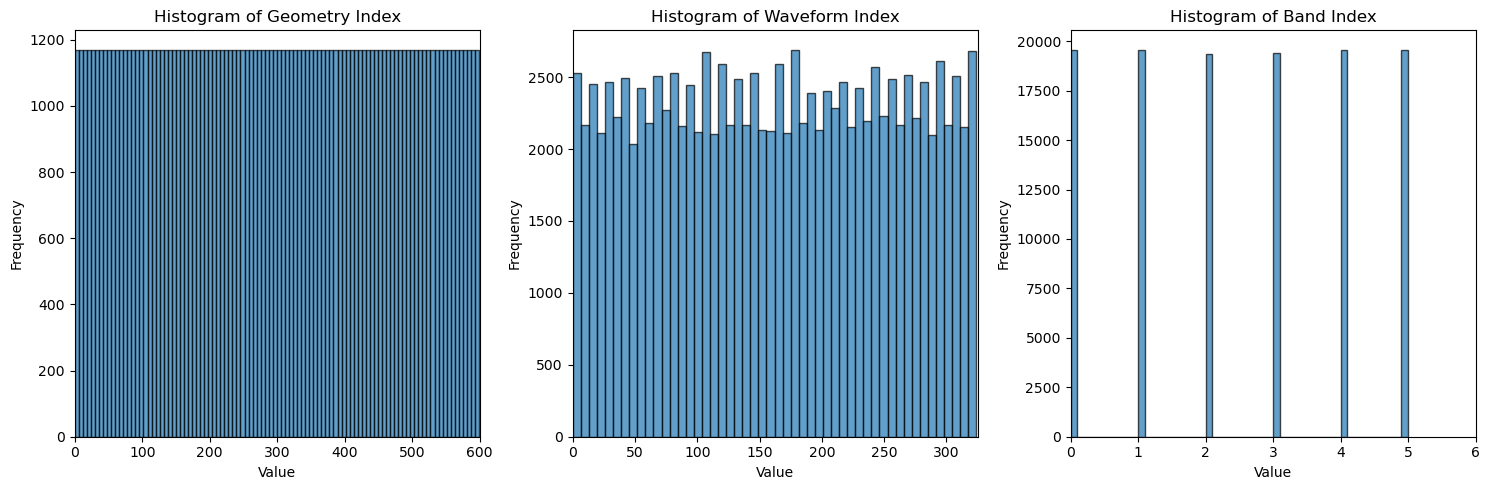

Shape of reduced_indices: (117000, 3)
Data type: int32


In [59]:
# Load the 8th reduced dataset
dataset_path = 'set8_f16_reduced_wv5_b2'
reduced_indices = torch.load(os.path.join('data',dataset_path, "reduced_indices.pt"))

# Convert (g, w, b) to numpy for easier plotting
reduced_indices_np = np.array(reduced_indices)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First number histogram (geometry index)
axes[0].hist(reduced_indices_np[:, 0], bins=100, alpha=0.7, edgecolor='black')
axes[0].set_title('Histogram of Geometry Index')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0, 600)

# Second number histogram (waveform index)
axes[1].hist(reduced_indices_np[:, 1], bins=50, alpha=0.7, edgecolor='black')
axes[1].set_title('Histogram of Waveform Index')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 325)

# Third number histogram (band index)
axes[2].hist(reduced_indices_np[:, 2], bins=50, alpha=0.7, edgecolor='black')
axes[2].set_title('Histogram of Band Index')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')
axes[2].set_xlim(0, 6)

plt.tight_layout()
plt.show()

print(f"Shape of reduced_indices: {reduced_indices_np.shape}")
print(f"Data type: {reduced_indices_np.dtype}")
